In [1]:
from fastai.vision.all import *
from fastcore.parallel import *
import timm

In [2]:
path = Path.home()/'.fastai/data/paddy'; path

Path('/home/bilal/.fastai/data/paddy')

In [3]:
trn_path = path/'train_images'

In [4]:
files = get_image_files(trn_path); files

(#10407) [Path('/home/bilal/.fastai/data/paddy/train_images/hispa/103939.jpg'),Path('/home/bilal/.fastai/data/paddy/train_images/hispa/106442.jpg'),Path('/home/bilal/.fastai/data/paddy/train_images/hispa/105708.jpg'),Path('/home/bilal/.fastai/data/paddy/train_images/hispa/100789.jpg'),Path('/home/bilal/.fastai/data/paddy/train_images/hispa/107842.jpg'),Path('/home/bilal/.fastai/data/paddy/train_images/hispa/101076.jpg'),Path('/home/bilal/.fastai/data/paddy/train_images/hispa/109689.jpg'),Path('/home/bilal/.fastai/data/paddy/train_images/hispa/101515.jpg'),Path('/home/bilal/.fastai/data/paddy/train_images/hispa/109965.jpg'),Path('/home/bilal/.fastai/data/paddy/train_images/hispa/102479.jpg')...]

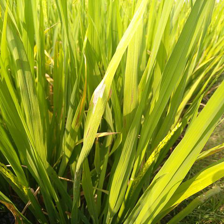

In [5]:
PILImage.create(files[0]).resize((224,224))

In [6]:
def f(o): return PILImage.create(o).size

In [7]:
%time sizes = parallel(f, files, n_workers=8)

CPU times: user 3.59 s, sys: 488 ms, total: 4.08 s
Wall time: 10.1 s


In [8]:
pd.DataFrame(list(sizes)).value_counts()

0    1  
480  640    10403
640  480        4
dtype: int64

In [10]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, bs=32, item_tfms=Resize(224))

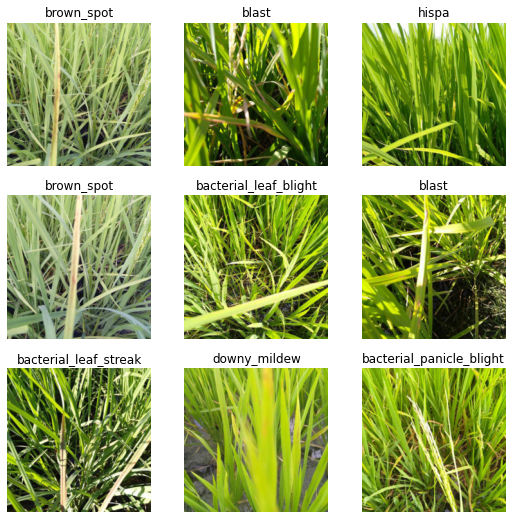

In [11]:
dls.show_batch()

In [18]:
timm.list_models('*convnext*')

['convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_small',
 'convnext_tiny',
 'convnext_tiny_hnf',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']

In [19]:
learn = vision_learner(dls, 'convnext_large_in22k', metrics=error_rate).to_fp16()

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_large_22k_224.pth" to /home/bilal/.cache/torch/hub/checkpoints/convnext_large_22k_224.pth


In [20]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.898594,0.575036,0.175877,00:50


epoch,train_loss,valid_loss,error_rate,time
0,0.458115,0.330686,0.098510,01:11
1,0.358188,0.217394,0.064873,01:11
2,0.197010,0.158115,0.048534,01:11
3,0.104390,0.132830,0.038924,01:11
4,0.068348,0.126626,0.036521,01:11


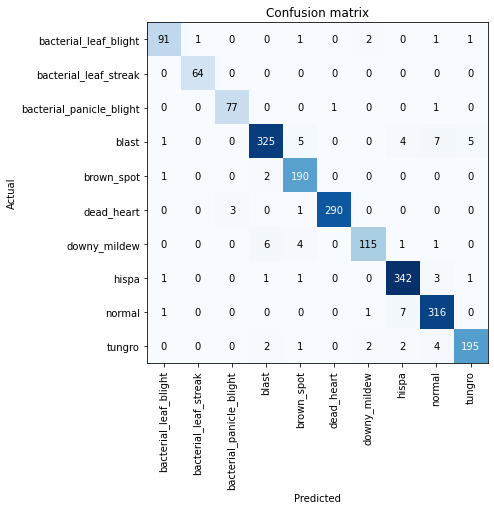

In [22]:
interp=ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(7,7))

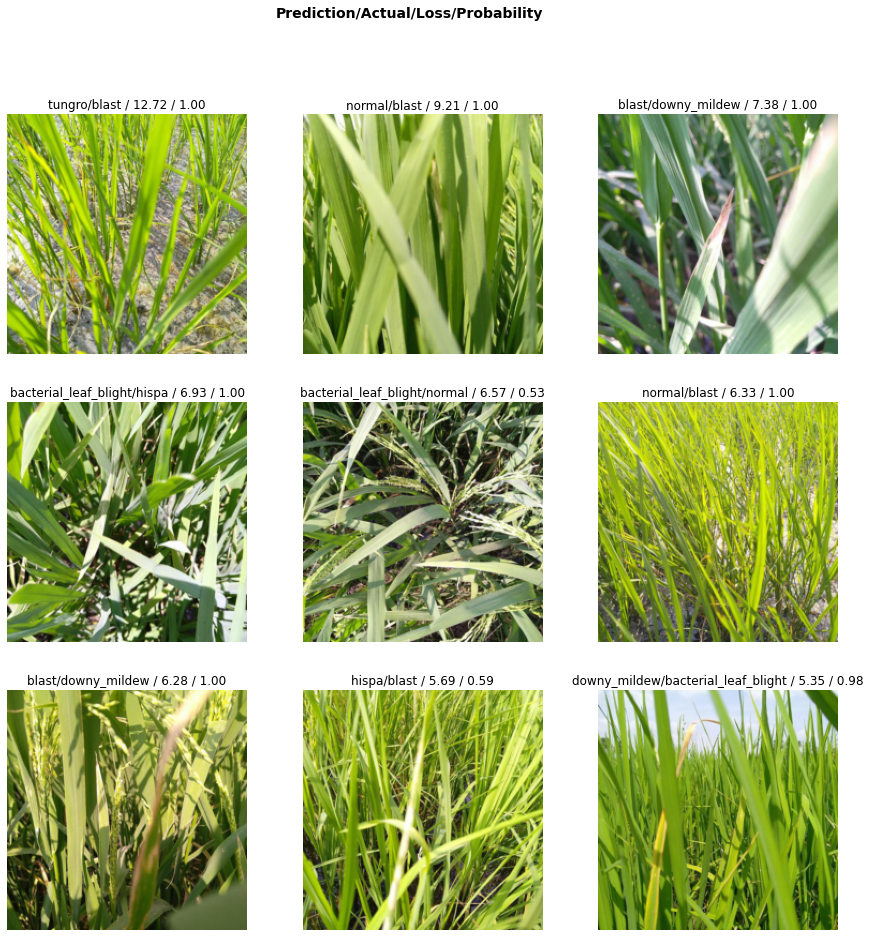

In [23]:
interp.plot_top_losses(9, figsize=(15,15))

In [30]:
test_files = get_image_files(path/'test_images').sorted(); test_files

(#3469) [Path('/home/bilal/.fastai/data/paddy/test_images/200001.jpg'),Path('/home/bilal/.fastai/data/paddy/test_images/200002.jpg'),Path('/home/bilal/.fastai/data/paddy/test_images/200003.jpg'),Path('/home/bilal/.fastai/data/paddy/test_images/200004.jpg'),Path('/home/bilal/.fastai/data/paddy/test_images/200005.jpg'),Path('/home/bilal/.fastai/data/paddy/test_images/200006.jpg'),Path('/home/bilal/.fastai/data/paddy/test_images/200007.jpg'),Path('/home/bilal/.fastai/data/paddy/test_images/200008.jpg'),Path('/home/bilal/.fastai/data/paddy/test_images/200009.jpg'),Path('/home/bilal/.fastai/data/paddy/test_images/200010.jpg')...]

In [31]:
test_dl=dls.test_dl(test_files)

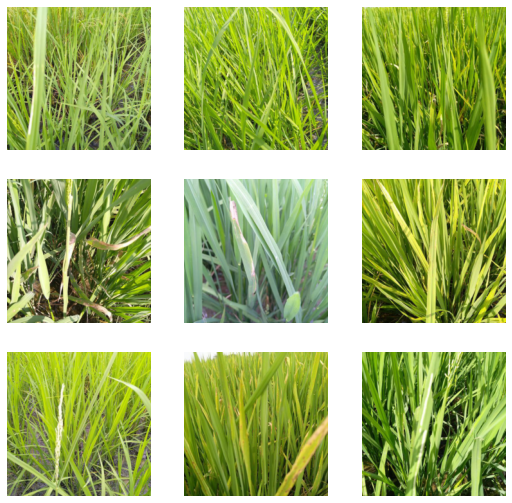

In [32]:
test_dl.show_batch()

In [35]:
probs, _, idxs=learn.get_preds(dl=test_dl, with_decoded=True)

In [36]:
idxs = pd.Series(idxs.numpy(),name="idxs")

In [37]:
sample_submit = pd.read_csv(path/'sample_submission.csv')

In [38]:
sample_submit.head()

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN


In [43]:
mapping = {k:v for k,v in enumerate(dls.vocab)};mapping

{0: 'bacterial_leaf_blight',
 1: 'bacterial_leaf_streak',
 2: 'bacterial_panicle_blight',
 3: 'blast',
 4: 'brown_spot',
 5: 'dead_heart',
 6: 'downy_mildew',
 7: 'hispa',
 8: 'normal',
 9: 'tungro'}

In [44]:
result=idxs.map(mapping); result

0                       hispa
1                      normal
2                       blast
3                       blast
4                       blast
                ...          
3464               dead_heart
3465                    hispa
3466                   normal
3467    bacterial_leaf_streak
3468               dead_heart
Name: idxs, Length: 3469, dtype: object

In [50]:
sample_submit['label'] = result
sample_submit.head()

,image_id,label
0,200001.jpg,hispa
1,200002.jpg,normal
2,200003.jpg,blast
3,200004.jpg,blast
4,200005.jpg,blast


In [51]:
sample_submit.to_csv('my_submit_convnext_large_in22k.csv', index=False)

In [52]:
!kaggle competitions submit -f ~/mlworks/plant_disease_detection/sample_submit_convnext_large_in22k.csv -m 'convnext_large_in22k 5 epochs' paddy-disease-classification

100%|██████████████████████████████████████| 70.5k/70.5k [00:01<00:00, 53.3kB/s]
Successfully submitted to Paddy Doctor: Paddy Disease Classification